In [1]:
#!pip install --upgrade git+https://github.com/EmGarr/kerod.git

In [2]:
#%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import  functools
import  tensorflow as tf
import  tensorflow_datasets as tfds
from    tensorflow.keras.utils import to_categorical
import  matplotlib.pyplot as plt
from    tensorflow.keras import layers
from    tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D




In [5]:
data_dir='/home/suphale/coco'
N_LABELS = 80
N_EPOCHS = 1
TRAIN_MODE = False
split_train = "train[:1%]"
split_val = "validation[:1%]"
h_image_height = 299
h_image_width = 299


In [6]:
class BoxField:
    BOXES = 'bbox'
    KEYPOINTS = 'keypoints'
    LABELS = 'label'
    MASKS = 'masks'
    NUM_BOXES = 'num_boxes'
    SCORES = 'scores'
    WEIGHTS = 'weights'

class DatasetField:
    IMAGES = 'images'
    IMAGES_INFO = 'images_information'
    IMAGES_PMASK = 'images_padding_mask'

def my_preprocess(inputs):
    image = inputs['image']
    image = tf.image.resize(image, (h_image_height, h_image_width))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.

    targets = inputs['objects']

    image_information = tf.cast(tf.shape(image)[:2], dtype=tf.float32)

    inputs = {DatasetField.IMAGES: image, DatasetField.IMAGES_INFO: image_information}

    # ground_truths = {
    #     BoxField.BOXES: targets[BoxField.BOXES] * tf.tile(image_information[tf.newaxis], [1, 2]),
    #     BoxField.LABELS: tf.cast(targets[BoxField.LABELS], tf.int32),
    #     BoxField.NUM_BOXES: tf.shape(targets[BoxField.LABELS]),
    #     BoxField.WEIGHTS: tf.fill(tf.shape(targets[BoxField.LABELS]), 1.0)
    # }
    ground_truths = tf.cast(targets[BoxField.LABELS], tf.int32)
    ground_truths = tf.one_hot(ground_truths, depth=N_LABELS, dtype=tf.int32)
    ground_truths = tf.reduce_sum(ground_truths, 0)
    ground_truths = tf.greater( ground_truths, tf.constant( 0 ) )    
    ground_truths = tf.where (ground_truths, 1, 0) 
    return image, ground_truths

def expand_dims_for_single_batch(image, ground_truths):
    image = tf.expand_dims(image, axis=0)
    ground_truths = tf.expand_dims(ground_truths, axis=0)
    return image, ground_truths


In [7]:
ds_train, ds_info = tfds.load(name="coco/2017", split=split_train, data_dir=data_dir, shuffle_files=True, download=False, with_info=True)
ds_train = ds_train.map(functools.partial(my_preprocess), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(expand_dims_for_single_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tfds.load(name="coco/2017", split=split_val, data_dir=data_dir, shuffle_files=True, download=False)
ds_val = ds_val.map(functools.partial(my_preprocess), num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(expand_dims_for_single_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Load and train the network


In [8]:
# Find total number of classes in the coco dataset
classes = ds_info.features['objects']['label'].names
num_classes = len(classes)
print(num_classes)

80


In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

x = image_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(80, activation='sigmoid')(x)

model = tf.keras.Model(inputs=image_model.input, outputs=predictions)

for layer in image_model.layers:
    layer.trainable = False

# model.compile(optimizer='rmsprop', loss=ncce, metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [10]:
# for layer in model.layers:
#     print(layer.trainable)

In [11]:
if (TRAIN_MODE == True):
    callbacks = [
        TensorBoard(),
        ModelCheckpoint('checkpoints/')
    ]

    model.fit(ds_train, validation_data=ds_val, epochs=N_EPOCHS, callbacks=callbacks)
    # Save the weights for the serving
    model.save_weights('/home/suphale/WorkSpace/temp_model/coco_classification_weights.h5')
else:
    model.load_weights('/home/suphale/WorkSpace/saved_model/coco_classification_weights.h5')    


## Visualisation of few images

Reference:
person, bus, book, 
Prediction:
bus(0.99), 


Reference:
person, car, handbag, 
Prediction:
person(0.96), skateboard(0.89), 


Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 


Reference:
remote, book, 
Prediction:
bottle(0.54), 


Reference:
remote, book, 
Prediction:
bottle(0.54), 


Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 


Reference:
person, bus, book, 
Prediction:
bus(0.99), 


Reference:
person, bus, book, 
Prediction:
bus(0.99), 


Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 


Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 


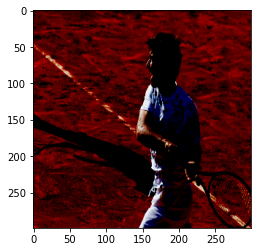

In [12]:
for test_index in range(10):
    sample_img_batch, sample_cap_batch = next(iter(ds_val))
    s = model(sample_img_batch)
    plt.imshow(tf.squeeze(sample_img_batch, [0]))

    print("Reference:")
    n = sample_cap_batch.numpy()
    index = 0
    for x in n[0]:
        if x > 0.1:
            print("%s," % (classes[index]), end=' ')
        index += 1
    print("")
    print("Prediction:")
    n = s.numpy()
    index = 0
    for x in n[0]:
        if x > 0.5:
            print("%s(%.2f)," % (classes[index],x), end=' ')
        index += 1
    print("")


## Tensorboard

In [13]:
TensorBoard = False
if(TensorBoard == True):
    # Load TENSORBOARD
    %load_ext tensorboard
    # Start TENSORBOARD
    %tensorboard --logdir logs

### Load the dataset

### Super dirty but the evaluation works

1. perform the analysis

2. install the coco library to compute the performances

In [14]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip annotations_trainval2017.zip
# !pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

3. compute the performances

In [15]:
# ds_info
old_model = tf.keras.models.load_model('model')

In [16]:
len(old_model.layers)


314

In [17]:
# old_model.summary(line_length=150)

In [18]:
sample_img_batch, sample_cap_batch = next(iter(ds_val))
# s = model(sample_img_batch)
# plt.imshow(tf.squeeze(sample_img_batch, [0]))


In [19]:
last_encoder_layer = 3

# hidden_layer = old_model.layers[last_encoder_layer].output

head_model = tf.keras.Model(inputs=old_model.input, outputs=old_model.layers[last_encoder_layer].output)

hidden_layer = head_model(sample_img_batch)
print(type(old_model.layers[last_encoder_layer]))
print(tf.shape(hidden_layer))
# head_model_output = head_model.output
# tf.keras.Input(old_model.layers[2])
# tail_model = tf.keras.Model(inputs=tf.keras.Input(old_model.layers[2]), outputs=old_model.output)

head_model.summary(line_length=150)



<class 'tensorflow.python.keras.layers.core.Activation'>
tf.Tensor([  1 149 149  32], shape=(4,), dtype=int32)
Model: "model_1"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_1 (InputLayer)                                               [(None, None, None, 3)]                                     0                      
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                                    (None, None, None, 32)                                      864                    
_____________________________________________________________________________________________________________________

In [20]:

len(old_model.layers)



314

In [21]:
from tensorflow import keras  # or import keras for standalone version
from tensorflow.keras.layers import Input

org_model = tf.keras.models.load_model('model')
new_model = tf.keras.models.load_model('model')


In [22]:
head_model_config = head_model.get_config()
# head_model_config

In [23]:
model_config = new_model.get_config()

In [24]:
model_config.keys()

dict_keys(['name', 'layers', 'input_layers', 'output_layers'])

In [25]:
max_layer_index = len(model_config['layers']) - 1

In [26]:
model_config['name']

'model'

In [27]:
model_config['output_layers']

split_layer = 4

new_head_model_config = {}
new_head_model_config['name'] = 'head_model'
new_head_model_config['layers'] = []
new_head_model_config['input_layers'] = [[model_config['layers'][0]['name'],0,0]]
new_head_model_config['output_layers'] = [[model_config['layers'][split_layer-1]['name'],0,0]]

for index in range(split_layer):
    print("%d %s" % (index, model_config['layers'][index]['name']) )
    new_head_model_config['layers'].append(model_config['layers'][index])

0 input_1
1 conv2d
2 batch_normalization
3 activation


In [28]:
# model_config['layers'][max_layer_len-1]['name']

In [29]:
import json
import copy

new_tail_model_config = copy.deepcopy(model_config)
# new_tail_model_config = json.loads(json.dumps(model_config))
new_tail_model_config['name'] = 'tail_model'
# new_tail_model_config['layers'] = []
new_tail_model_config['input_layers'] = [[model_config['layers'][split_layer]['name'],0,0]]
new_tail_model_config['output_layers'] = [[model_config['layers'][max_layer_index]['name'],0,0]]

In [30]:
new_input_layer = {
                      'name': 'new_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None, None, None, 32),
                          'dtype': 'float32',
                          'sparse': False,
                          'name': 'new_input'
                      },
                      'inbound_nodes': []
                  }
new_tail_model_config['layers'][0] = new_input_layer

In [31]:
for index in range(1,split_layer):
    print("%d %s" % (index, new_tail_model_config['layers'][1]['name']) )
    # new_tail_model_config['layers'].append(model_config['layers'][index])
    new_tail_model_config['layers'].pop(1)

1 conv2d
2 batch_normalization
3 activation


In [32]:
# input_layer_name = model_config['layers'][0]['name']
new_tail_model_config['layers'][1]['inbound_nodes'] = [[['new_input', 0, 0, {}]]]
new_tail_model_config['input_layers'] = [['new_input', 0, 0]]

In [33]:
import pprint

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(model_config['layers'][4])


{   'class_name': 'Conv2D',
    'config': {   'activation': 'linear',
                  'activity_regularizer': None,
                  'bias_constraint': None,
                  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
                  'bias_regularizer': None,
                  'data_format': 'channels_last',
                  'dilation_rate': (1, 1),
                  'dtype': 'float32',
                  'filters': 32,
                  'groups': 1,
                  'kernel_constraint': None,
                  'kernel_initializer': {   'class_name': 'GlorotUniform',
                                            'config': {'seed': None}},
                  'kernel_regularizer': None,
                  'kernel_size': (3, 3),
                  'name': 'conv2d_1',
                  'padding': 'valid',
                  'strides': (1, 1),
                  'trainable': True,
                  'use_bias': False},
    'inbound_nodes': [[['activation', 0, 0, {}]]],
    'n

In [34]:
pp.pprint(new_tail_model_config['layers'][1])


{   'class_name': 'Conv2D',
    'config': {   'activation': 'linear',
                  'activity_regularizer': None,
                  'bias_constraint': None,
                  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
                  'bias_regularizer': None,
                  'data_format': 'channels_last',
                  'dilation_rate': (1, 1),
                  'dtype': 'float32',
                  'filters': 32,
                  'groups': 1,
                  'kernel_constraint': None,
                  'kernel_initializer': {   'class_name': 'GlorotUniform',
                                            'config': {'seed': None}},
                  'kernel_regularizer': None,
                  'kernel_size': (3, 3),
                  'name': 'conv2d_1',
                  'padding': 'valid',
                  'strides': (1, 1),
                  'trainable': True,
                  'use_bias': False},
    'inbound_nodes': [[['new_input', 0, 0, {}]]],
    'na

In [35]:
import pprint
with open('model_config.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    # fh.write(str(model_config))
    pp = pprint.PrettyPrinter(indent=4, stream=fh)
    pp.pprint(str(model_config))
with open('head_model_config.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    pp = pprint.PrettyPrinter(indent=4, stream=fh)
    pp.pprint(str(head_model_config))
    # fh.write(str(head_model_config))
with open('new_head_model_config.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    # fh.write(str(new_head_model_config))
    pp = pprint.PrettyPrinter(indent=4, stream=fh)
    pp.pprint(str(new_head_model_config))
with open('new_tail_model_config.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    # fh.write(str(new_head_model_config))
    pp = pprint.PrettyPrinter(indent=4, stream=fh)
    pp.pprint(str(new_tail_model_config))


In [36]:
new_head_model = new_model.__class__.from_config(new_head_model_config, custom_objects={})


In [37]:
new_model.__class__

tensorflow.python.keras.engine.functional.Functional

In [38]:
new_tail_model = new_model.__class__.from_config(new_tail_model_config, custom_objects={})


In [39]:
with open('org_model.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    org_model.summary(print_fn=lambda x: fh.write(x + '\n'), line_length=150)

with open('new_head_model.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    new_head_model.summary(print_fn=lambda x: fh.write(x + '\n'), line_length=150)

with open('new_tail_model.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    new_tail_model.summary(print_fn=lambda x: fh.write(x + '\n'), line_length=150)


In [46]:
for index, layer in enumerate(org_model.layers[:split_layer]):
    # print("[%d] %s %s" % (index, layer.name, str(np.shape(weight))))
    weight = layer.get_weights()
    new_head_model_layer = new_head_model.layers[index]
    new_head_model_layer.set_weights(weight)


[0] input_1 (1, 3, 3, 32, 32)
[1] conv2d (0,)
[2] batch_normalization (1, 3, 3, 3, 32)
[3] activation (3, 32)


In [52]:
for index, layer in enumerate(org_model.layers):
    weight = layer.get_weights()
    # print("[%d] %s %s" % (index, layer.name, str(np.shape(weight))))


[0] input_1 (0,)
[1] conv2d (1, 3, 3, 3, 32)
[2] batch_normalization (3, 32)
[3] activation (0,)
[4] conv2d_1 (1, 3, 3, 32, 32)
[5] batch_normalization_1 (3, 32)
[6] activation_1 (0,)
[7] conv2d_2 (1, 3, 3, 32, 64)
[8] batch_normalization_2 (3, 64)
[9] activation_2 (0,)
[10] max_pooling2d (0,)
[11] conv2d_3 (1, 1, 1, 64, 80)
[12] batch_normalization_3 (3, 80)
[13] activation_3 (0,)
[14] conv2d_4 (1, 3, 3, 80, 192)
[15] batch_normalization_4 (3, 192)
[16] activation_4 (0,)
[17] max_pooling2d_1 (0,)
[18] conv2d_8 (1, 1, 1, 192, 64)
[19] batch_normalization_8 (3, 64)
[20] activation_8 (0,)
[21] conv2d_6 (1, 1, 1, 192, 48)
[22] conv2d_9 (1, 3, 3, 64, 96)
[23] batch_normalization_6 (3, 48)
[24] batch_normalization_9 (3, 96)
[25] activation_6 (0,)
[26] activation_9 (0,)
[27] average_pooling2d (0,)
[28] conv2d_5 (1, 1, 1, 192, 64)
[29] conv2d_7 (1, 5, 5, 48, 64)
[30] conv2d_10 (1, 3, 3, 96, 96)
[31] conv2d_11 (1, 1, 1, 192, 32)
[32] batch_normalization_5 (3, 64)
[33] batch_normalization_7 (3,

In [57]:
org_model.layers[4].name

'conv2d_1'

In [59]:
for index, layer in enumerate(org_model.layers[split_layer:max_layer_index+1]):
    weight = layer.get_weights()
    # print("[%d] %s %s" % (index, layer.name, str(np.shape(weight))))
    new_tail_model_layer = new_tail_model.layers[index+1]
    # print("[%d] %s %s" % (index, new_tail_model_layer.name, str(np.shape(weight))))
    new_tail_model_layer.set_weights(weight)



[0] conv2d_1 (1, 3, 3, 32, 32)
[0] conv2d_1 (1, 3, 3, 32, 32)
[1] batch_normalization_1 (3, 32)
[1] batch_normalization_1 (3, 32)
[2] activation_1 (0,)
[2] activation_1 (0,)
[3] conv2d_2 (1, 3, 3, 32, 64)
[3] conv2d_2 (1, 3, 3, 32, 64)
[4] batch_normalization_2 (3, 64)
[4] batch_normalization_2 (3, 64)
[5] activation_2 (0,)
[5] activation_2 (0,)
[6] max_pooling2d (0,)
[6] max_pooling2d (0,)
[7] conv2d_3 (1, 1, 1, 64, 80)
[7] conv2d_3 (1, 1, 1, 64, 80)
[8] batch_normalization_3 (3, 80)
[8] batch_normalization_3 (3, 80)
[9] activation_3 (0,)
[9] activation_3 (0,)
[10] conv2d_4 (1, 3, 3, 80, 192)
[10] conv2d_4 (1, 3, 3, 80, 192)
[11] batch_normalization_4 (3, 192)
[11] batch_normalization_4 (3, 192)
[12] activation_4 (0,)
[12] activation_4 (0,)
[13] max_pooling2d_1 (0,)
[13] max_pooling2d_1 (0,)
[14] conv2d_8 (1, 1, 1, 192, 64)
[14] conv2d_8 (1, 1, 1, 192, 64)
[15] batch_normalization_8 (3, 64)
[15] batch_normalization_8 (3, 64)
[16] activation_8 (0,)
[16] activation_8 (0,)
[17] conv2d_6 

In [60]:
# import numpy as np
# # weights = [layer.get_weights() for layer in org_model.layers]
# for index, layer in enumerate(org_model.layers):
#     weight = layer.get_weights()
#     print("O [%d] %s %s" % (index, layer.name, str(np.shape(weight))))

    # new_model_layer = new_model.layers[index]
    # print("N [%d] %s %s" % (index, new_model_layer.name, str(np.shape(new_model_layer.get_weights()))))
    # new_model_layer.set_weights(weight)
    # print(layer)
# len(weights[1][0][0][0][0])
# for layer, weight in zip(new_model.layers[2:], weights):
#     print(tf.shape(weights))
#     # print(layer)
#     # layer.set_weights(weight)

In [61]:
# iterate over all the layers that we want to get weights from
# weights = [layer.get_weights() for layer in model.layers[2:]]
# for layer, weight in zip(new_model.layers[2:], weights):
#     # print(layer)
#     layer.set_weights(weight)

In [42]:
# tail_model = tf.keras.Model(inputs=old_model.layers[0], outputs=old_model.output)
# decoder.summary(line_length=150)


In [62]:
last_encoder_layer = 3

hidden_layer = new_head_model(sample_img_batch)
# print(type(old_model.layers[last_encoder_layer]))
print(tf.shape(hidden_layer))
# head_model_output = head_model.output
# tf.keras.Input(old_model.layers[2])
# tail_model = tf.keras.Model(inputs=tf.keras.Input(old_model.layers[2]), outputs=old_model.output)

new_head_model.summary(line_length=150)



tf.Tensor([  1 149 149  32], shape=(4,), dtype=int32)
Model: "head_model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_1 (InputLayer)                                               [(None, None, None, 3)]                                     0                      
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                                    (None, None, None, 32)                                      864                    
______________________________________________________________________________________________________________________________________________________
batch_normalization 

In [65]:
tf.shape(hidden_layer)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 149, 149,  32], dtype=int32)>

In [63]:
predictions = new_tail_model(hidden_layer)
# # head_model.summary(line_length=150)
print(tf.shape(predictions))


tf.Tensor([ 1 80], shape=(2,), dtype=int32)


In [64]:
for test_index in range(10):
    sample_img_batch, sample_cap_batch = next(iter(ds_val))
    h = new_head_model(sample_img_batch)
    s = new_tail_model(h)

    # plt.imshow(tf.squeeze(sample_img_batch, [0]))

    print("Reference:")
    n = sample_cap_batch.numpy()
    index = 0
    for x in n[0]:
        if x > 0.1:
            print("%s," % (classes[index]), end=' ')
        index += 1
    print("")
    print("Prediction:")
    n = s.numpy()
    index = 0
    for x in n[0]:
        if x > 0.5:
            print("%s(%.2f)," % (classes[index],x), end=' ')
        index += 1
    print("")

Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 
Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 
Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 
Reference:
person, car, handbag, 
Prediction:
person(0.96), skateboard(0.89), 
Reference:
person, tennis racket, 
Prediction:
person(0.99), sports ball(0.52), tennis racket(1.00), 
Reference:
remote, book, 
Prediction:
bottle(0.54), 
Reference:
bottle, cup, oven, sink, 
Prediction:
oven(0.53), sink(0.63), 
Reference:
person, car, handbag, 
Prediction:
person(0.96), skateboard(0.89), 
Reference:
person, bus, book, 
Prediction:
bus(0.99), 
Reference:
person, car, handbag, 
Prediction:
person(0.96), skateboard(0.89), 
